Before we even start, we should be give an introduction of CNN 

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle                      
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import matplotlib.gridspec as gridspec
from random import randint

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
print(class_names_label)
IMAGE_SIZE = (150, 150)

{'mountain': 0, 'street': 1, 'glacier': 2, 'buildings': 3, 'sea': 4, 'forest': 5}


In [3]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = [r'C:\Users\ziyan\OneDrive\NTU BCG Y1S2 2022\SC1015 Intro to DSAI\SC1015 project\seg_train', r"C:\Users\ziyan\OneDrive\NTU BCG Y1S2 2022\SC1015 Intro to DSAI\SC1015 project\seg_test"]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:\Users\ziyan\OneDrive\NTU BCG Y1S2 2022\SC1015 Intro to DSAI\SC1015 project\seg_train


100%|██████████| 2382/2382 [00:03<00:00, 782.94it/s]


Loading C:\Users\ziyan\OneDrive\NTU BCG Y1S2 2022\SC1015 Intro to DSAI\SC1015 project\seg_test


100%|██████████| 501/501 [00:00<00:00, 772.06it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

# Let's explore the dataset
##  We can ask ourselves:

- How many training and testing examples do we have ?


- What is the size of the images ?


- What is the proportion of each observed category ?

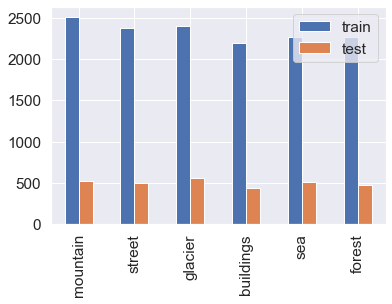

In [6]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

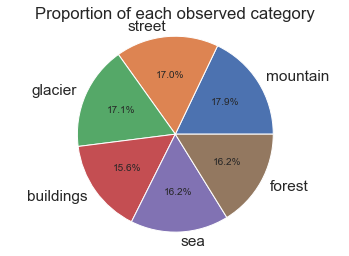

In [7]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

# Good practice: scale the data
- To reduce this we can normalize the values to range from 0 to 1. In this way, the numbers will be small and the computation becomes easier and faster. As the pixel values range from 0 to 256, apart from 0 the range is 255. So dividing all the values by 255 will convert it to range from 0 to 1

In [8]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

# Visualize the data
We can display a random image from the training set.

In [9]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

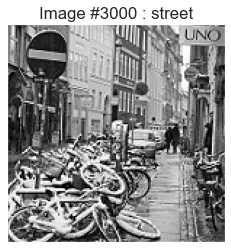

In [10]:
display_random_image(class_names, train_images, train_labels)


We can also display the first 25 images from the training set directly with a loop to get a better view

In [11]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

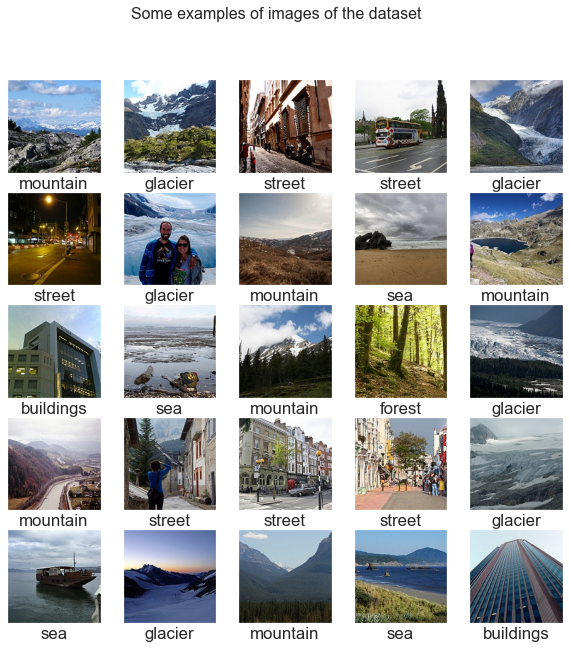

In [12]:
display_examples(class_names, train_images, train_labels)

# Beginner: Simple Model Creation
(for this we should set this as our base case for the CNN model)
Steps are:

- Build the model,
- Compile the model,
- Train / fit the data to the model,
- Evaluate the model on the testing set,
- Carry out an error analysis of our model.


We can build an easy model composed of different layers such as:


- Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
- MaxPooling2D: The images get half sized.
- Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
- Relu : given a value x, returns max(x, 0).
- Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [13]:
#Baseline model1
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), #kernal size is 3x3 and there are 32 filters
    tf.keras.layers.MaxPooling2D(2,2), #2 by 2 maxpooling layer
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'), #kernal size 3x3 and there are 32 filters
    tf.keras.layers.MaxPooling2D(2,2), #max pooling is where we scale down the output of the convolutional layers by keeping only the largest values and throwing away the smaller ones
    tf.keras.layers.Flatten(), #finally there is flattening bc there is a fully connected network coming next, 0 paramter for maxpool and flatten as it computes a fixed function of the input.And we not working with 2D data 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), #128 output nodes
    tf.keras.layers.Dense(6, activation=tf.nn.softmax) #6 output one of the 6 classes we use softmax
])
model1.summary()
#para is the total number of weights in that layer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

# Maybe here can add picture of what our base model will look like

In [14]:
#this is where we compile the model
model1.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
history1 = model1.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 113s 1s/step - loss: 1.2461 - accuracy: 0.5544 - val_loss: 0.8416 - val_accuracy: 0.6929
Epoch 2/20
88/88 [==============================] - 109s 1s/step - loss: 0.7300 - accuracy: 0.7344 - val_loss: 0.6851 - val_accuracy: 0.7478
Epoch 3/20
88/88 [==============================] - 108s 1s/step - loss: 0.5522 - accuracy: 0.8051 - val_loss: 0.6548 - val_accuracy: 0.7663
Epoch 4/20
88/88 [==============================] - 109s 1s/step - loss: 0.4185 - accuracy: 0.8554 - val_loss: 0.6647 - val_accuracy: 0.7581
Epoch 5/20
88/88 [==============================] - 110s 1s/step - loss: 0.2997 - accuracy: 0.8993 - val_loss: 0.6731 - val_accuracy: 0.7798
Epoch 6/20
88/88 [==============================] - 108s 1s/step - loss: 0.2238 - accuracy: 0.9288 - val_loss: 0.6861 - val_accuracy: 0.7773
Epoch 7/20
88/88 [==============================] - 107s 1s/step - loss: 0.1445 - accuracy: 0.9565 - val_loss: 0.7366 - val_accuracy: 0.7805
Epoch 8/20
88

In [16]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

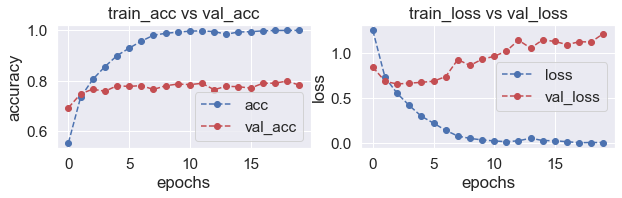

In [17]:
plot_accuracy_loss(history1)

In [18]:
test_loss = model1.evaluate(test_images, test_labels)

94/94 [==============================] - 6s 62ms/step - loss: 1.2927 - accuracy: 0.7767


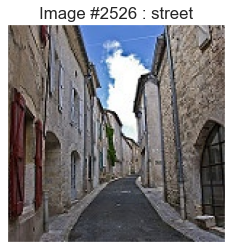

In [19]:
predictions = model1.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability
display_random_image(class_names, test_images, pred_labels)

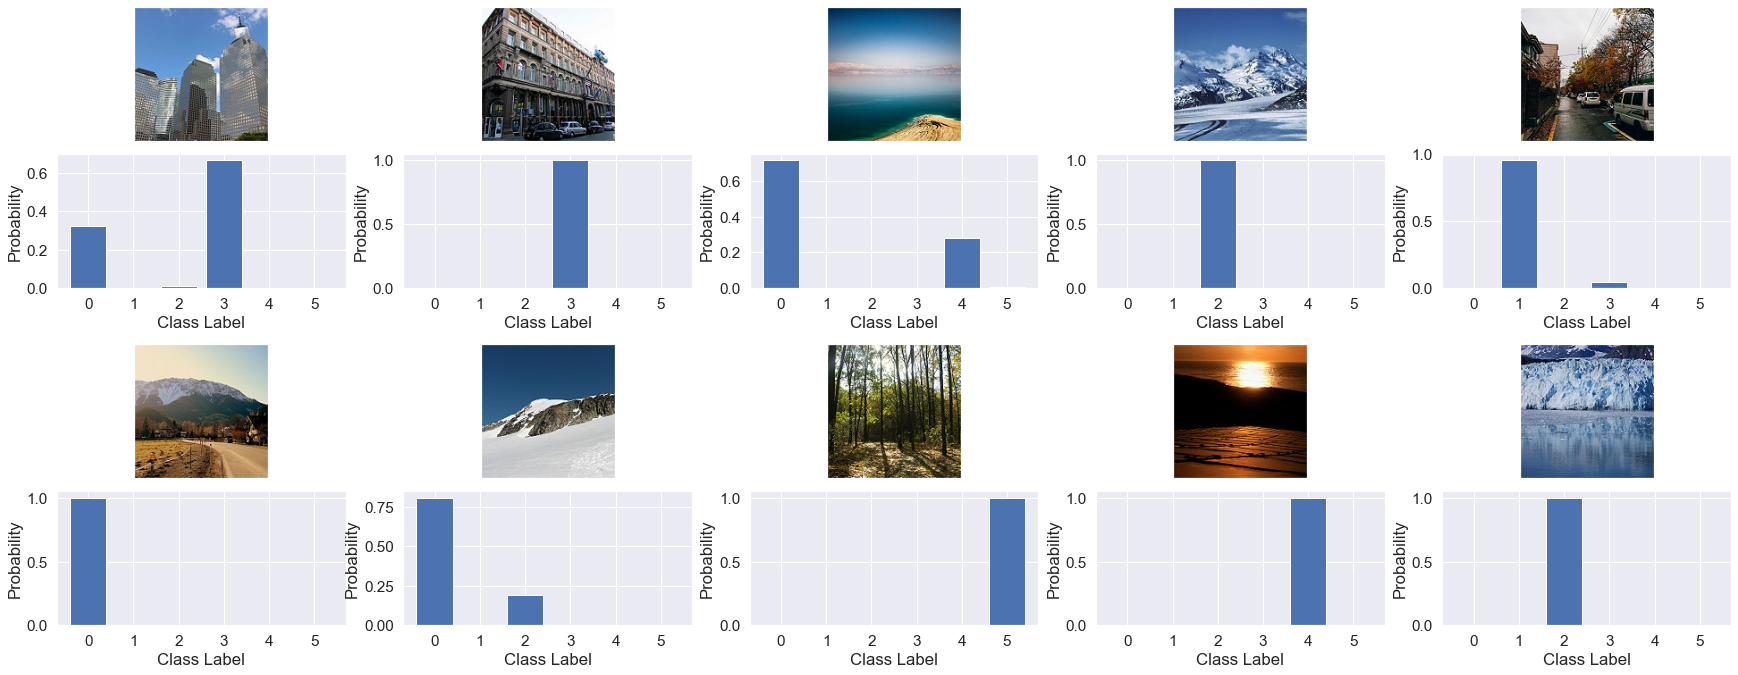

In [21]:
fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(10):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(test_images))
    pred_image = np.array([test_images[rnd_number]])
    pred_class = np.argmax(pred_image, axis = 1)
    pred_prob = model1.predict(pred_image).reshape(6)
    for j in range(2):
        if (j%2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            #ax.set_title(pred_class[0])
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)

        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)
            ax.set_xticks([0,1,2,3,4,5])
            # Set common labels
            ax.set_xlabel('Class Label')
            ax.set_ylabel('Probability')

plt.show()

# Error analysis


We can try to understand on which kind of images the classifier has trouble.

In [22]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

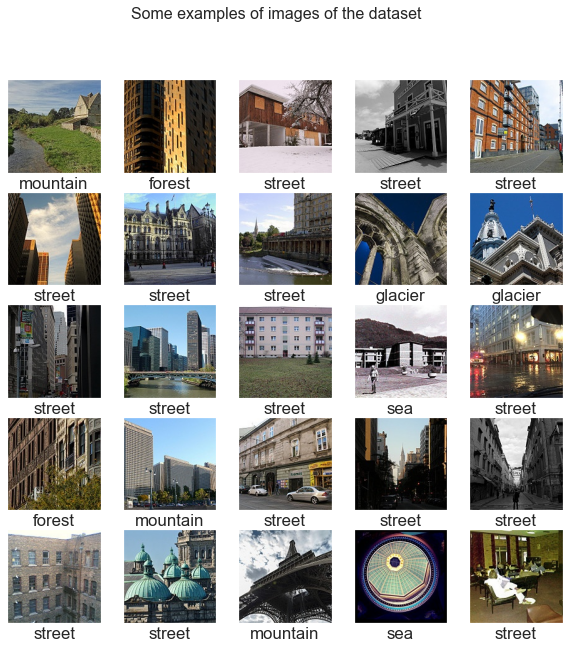

In [23]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

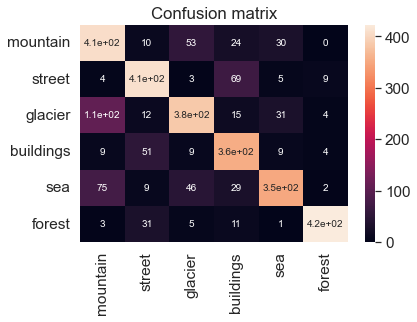

In [24]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

## Conclusion: The classifier has trouble with 2 kinds of images.


It has trouble with street and buildings. Well, it can be understandable as as there are buildings in the street. It has also trouble with sea, glacier and moutain as well. It is hard for me to fully distinguish them. However, it can detects forest very accurately!

# Doing different Model


In [25]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),  
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
]) #dropout is to prevent over fitting, the effect of the random dropout forces the network to learn a redundant representation of the data
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 32)       

In [26]:
model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
history2 = model2.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 130s 1s/step - loss: 1.5501 - accuracy: 0.3996 - val_loss: 1.1922 - val_accuracy: 0.5778
Epoch 2/20
88/88 [==============================] - 127s 1s/step - loss: 1.1342 - accuracy: 0.5561 - val_loss: 1.0823 - val_accuracy: 0.5992
Epoch 3/20
88/88 [==============================] - 126s 1s/step - loss: 1.0001 - accuracy: 0.6140 - val_loss: 0.9125 - val_accuracy: 0.6758
Epoch 4/20
88/88 [==============================] - 126s 1s/step - loss: 0.8859 - accuracy: 0.6723 - val_loss: 0.9430 - val_accuracy: 0.6762
Epoch 5/20
88/88 [==============================] - 128s 1s/step - loss: 0.8254 - accuracy: 0.6911 - val_loss: 0.7230 - val_accuracy: 0.7471
Epoch 6/20
88/88 [==============================] - 123s 1s/step - loss: 0.7738 - accuracy: 0.7195 - val_loss: 0.7601 - val_accuracy: 0.7357
Epoch 7/20
88/88 [==============================] - 120s 1s/step - loss: 0.7039 - accuracy: 0.7380 - val_loss: 0.6822 - val_accuracy: 0.7659
Epoch 8/20
88

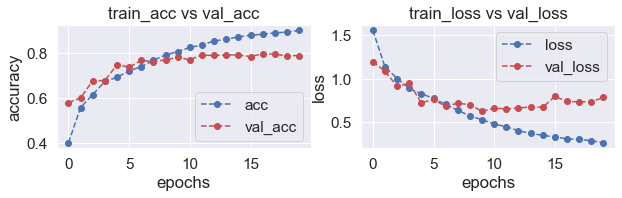

In [28]:
plot_accuracy_loss(history2)

In [29]:
test_loss = model2.evaluate(test_images, test_labels)

94/94 [==============================] - 6s 63ms/step - loss: 0.7448 - accuracy: 0.7943


In [30]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),  
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
]) #dropout is to prevent over fitting, the effect of the random dropout forces the network to learn a redundant representation of the data
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 36, 36, 32)       

In [31]:
model3.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
history3 = model3.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 140s 2s/step - loss: 1.5218 - accuracy: 0.3878 - val_loss: 1.2011 - val_accuracy: 0.5661
Epoch 2/20
88/88 [==============================] - 135s 2s/step - loss: 1.1157 - accuracy: 0.5578 - val_loss: 1.1681 - val_accuracy: 0.5572
Epoch 3/20
88/88 [==============================] - 133s 2s/step - loss: 1.0037 - accuracy: 0.6105 - val_loss: 0.9581 - val_accuracy: 0.6445
Epoch 4/20
88/88 [==============================] - 133s 2s/step - loss: 0.9251 - accuracy: 0.6444 - val_loss: 0.8334 - val_accuracy: 0.6997
Epoch 5/20
88/88 [==============================] - 133s 2s/step - loss: 0.8494 - accuracy: 0.6828 - val_loss: 0.7444 - val_accuracy: 0.7367
Epoch 6/20
88/88 [==============================] - 132s 2s/step - loss: 0.8174 - accuracy: 0.6943 - val_loss: 0.6943 - val_accuracy: 0.7667
Epoch 7/20
88/88 [==============================] - 132s 2s/step - loss: 0.7564 - accuracy: 0.7206 - val_loss: 0.6445 - val_accuracy: 0.7688
Epoch 8/20
88

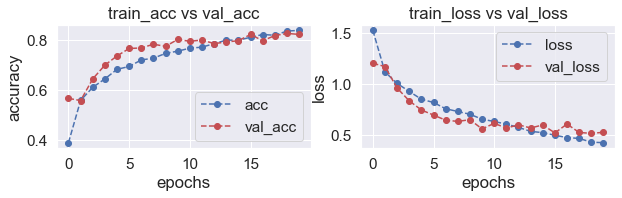

In [33]:
plot_accuracy_loss(history3)

In [34]:
test_loss = model3.evaluate(test_images, test_labels)

94/94 [==============================] - 6s 67ms/step - loss: 0.5179 - accuracy: 0.8277
